In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

Unknown instance spec: 

In [2]:
df = pd.read_csv('mtsamples.csv')
df = df.drop(columns='Unnamed: 0')
df

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


# Анализ данных

In [3]:
train_df, test_df = train_test_split(df, random_state=42, stratify=df['keywords'].isnull())

print("Размер тренировочного набора:", train_df.shape)
print("Размер тестового набора:", test_df.shape)

Размер тренировочного набора: (3749, 5)
Размер тестового набора: (1250, 5)


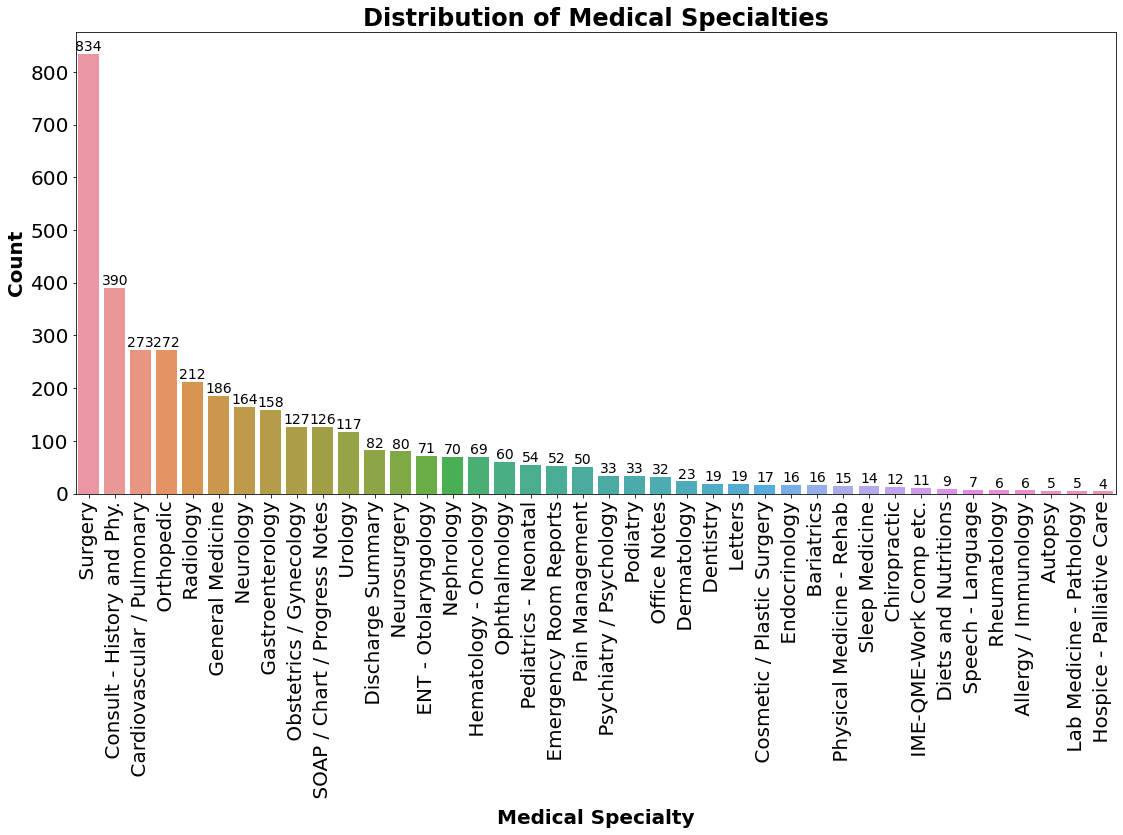

In [5]:
specialty_counts = train_df['medical_specialty'].value_counts()

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(16, 12))
bars = sns.barplot(x=specialty_counts.index, y=specialty_counts.values)
plt.title('Distribution of Medical Specialties', fontweight='bold')
plt.xlabel('Medical Specialty', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=90)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{int(bar.get_height())}',
             va='bottom',
             ha='center',
             color='black', 
             fontsize=14)

plt.tight_layout()
plt.show()

In [7]:
len(train_df['medical_specialty'].value_counts())

40

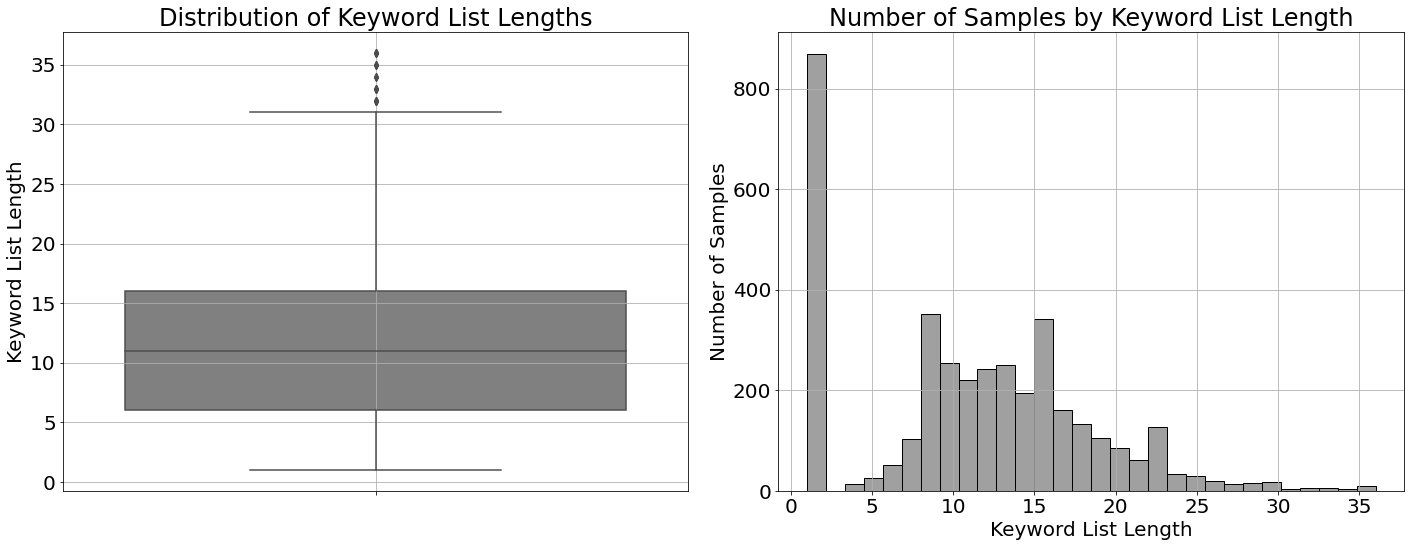

In [10]:
keyword_lengths = train_df['keywords'].apply(lambda x: len(str(x).split(',')))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=keyword_lengths, data=train_df, color='grey')
plt.title('Distribution of Keyword List Lengths')
plt.ylabel('Keyword List Length')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=keyword_lengths, bins=30, color='grey')
plt.title('Number of Samples by Keyword List Length')
plt.xlabel('Keyword List Length')
plt.ylabel('Number of Samples')
plt.grid(True)

plt.tight_layout()
plt.show()

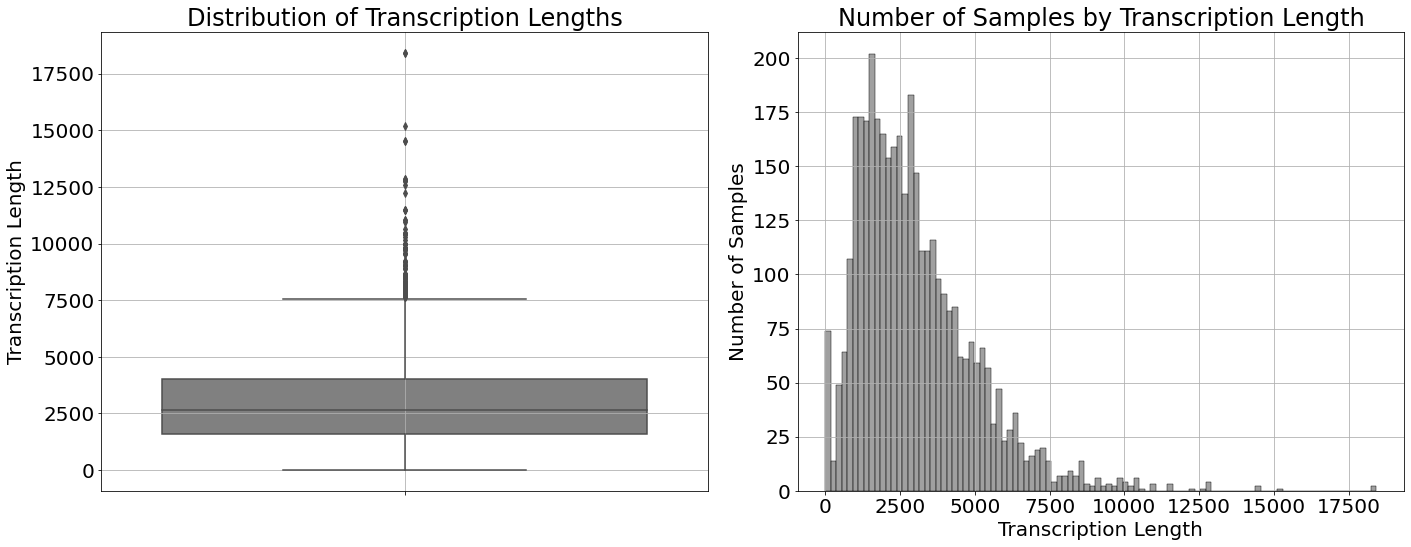

In [12]:
transcription_lengths = train_df['transcription'].apply(lambda x: len(str(x)))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=transcription_lengths, data=train_df, color='grey')
plt.title('Distribution of Transcription Lengths')
plt.ylabel('Transcription Length')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=transcription_lengths, bins=100, color='grey')
plt.title('Number of Samples by Transcription Length')
plt.xlabel('Transcription Length')
plt.ylabel('Number of Samples')
plt.grid(True)

plt.tight_layout()
plt.show()

# Создание словаря классов

In [3]:
pip install pandas nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import nltk
from nltk.corpus import wordnet as wn

word = "urology"

lemmatizer = nltk.WordNetLemmatizer()
root_word = lemmatizer.lemmatize(word)

related_words = set()
for synset in wn.synsets(root_word):
    for lemma in synset.lemmas():
        related_words.add(lemma.name())
        related_words.update([related_form.name() for related_form in lemma.derivationally_related_forms()])

print(related_words)

{'urogenital_medicine', 'urology', 'urologist'}


In [22]:
specialties_dict = {}
for item in df['medical_specialty'].unique():
    words = item.replace('-', '/').split('/')
    words = [word.strip().lower() for word in words]
    
    def find_related_words(word):
        lemmatizer = nltk.WordNetLemmatizer()
        root_word = lemmatizer.lemmatize(word)
        related_words = set()
        related_words.add(root_word) 
        for synset in wn.synsets(root_word):
            for lemma in synset.lemmas():
                related_words.add(lemma.name())
                related_words.update([related_form.name() for related_form in lemma.derivationally_related_forms()])
        return list(related_words)
    
    all_related_words = set()
    for word in words:
        all_related_words.update(find_related_words(word))
    
    specialties_dict[item] = list(all_related_words)

In [23]:
specialties_dict

{' Allergy / Immunology': ['xenogeneic',
  'allergic',
  'allergic_reaction',
  'immunology',
  'immunologic',
  'immunologist',
  'allergist',
  'immunological',
  'allogeneic',
  'allergy'],
 ' Bariatrics': ['bariatrics'],
 ' Cardiovascular / Pulmonary': ['cardiovascular',
  'pulmonary',
  'pneumonic',
  'pulmonic'],
 ' Neurology': ['neurologic',
  'clinical_neurology',
  'neurology',
  'neurologist',
  'neurological'],
 ' Dentistry': ['dental_medicine', 'odontology', 'dentistry'],
 ' Urology': ['urogenital_medicine', 'urology', 'urologist'],
 ' General Medicine': ['general medicine'],
 ' Surgery': ['operating_theatre',
  'surgical_process',
  'operation',
  'surgical_procedure',
  'surgical',
  'surgery',
  'surgical_operation',
  'operative',
  'operate',
  'operating_room',
  'operating_theater',
  'OR'],
 ' Speech - Language': ['language',
  'talking_to',
  'nomenclature',
  'linguistic_process',
  'speechify',
  'speech',
  'spoken_communication',
  'lecture',
  'voice_communica

In [25]:
import json

json_list = []
for key, value in specialties_dict.items():
    json_list.append({
        "class": key,
        "synonyms": value
    })

json_output = json.dumps(json_list, indent=2)
with open('classes4parser.json', 'w', encoding='utf-8') as f:
    f.write(json_output)

# BERT

## Предобработка данных

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaModel, RobertaTokenizer
from transformers import BertTokenizer
from keras.utils import pad_sequences

2024-05-11 17:30:01.786408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df = df.dropna(subset=['transcription'])
X = df['transcription'].tolist()
X = [str(text) for text in X if pd.notnull(text)]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['medical_specialty'])
y = encoded_labels

In [5]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, inputs['input_ids'].size(0), batch_size)):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = generate_embeddings(model, inputs)

100%|██████████| 311/311 [00:49<00:00,  6.28it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)

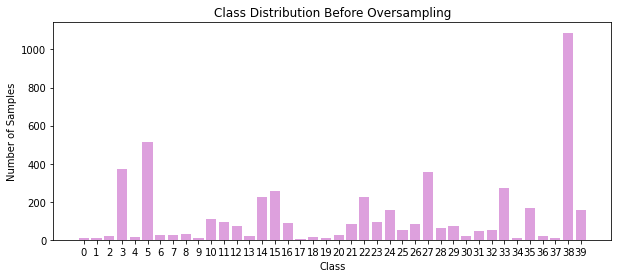

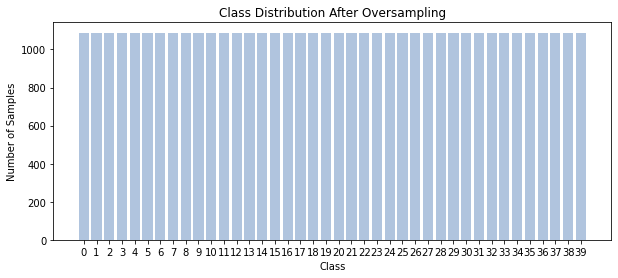

In [7]:
import matplotlib.pyplot as plt

unique_classes, counts_before = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_classes, counts_before, color='plum')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Oversampling')
plt.xticks(unique_classes)
plt.show()


unique_classes_resampled, counts_after = np.unique(labels_resampled, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_classes_resampled, counts_after, color='lightsteelblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Oversampling')
plt.xticks(unique_classes_resampled)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
hidden_dim = 256
num_classes = np.unique(y).shape[0]
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

## Обучение модели

In [11]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

epochs = 30
loss_values_train, loss_values_val, f1_values = [], [], []

for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(b_input_ids)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    loss_values_train.append(avg_train_loss)

    mlp_model.eval()
    eval_loss = 0
    predictions, true_labels = [], []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for batch in tqdm(val_loader, desc="Validation", total=len(val_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        
        with torch.no_grad():
            outputs = mlp_model(b_input_ids)
        
        loss = criterion(outputs, b_labels)
        eval_loss += loss.item()

        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)

    eval_loss = eval_loss / len(val_loader)
    loss_values_val.append(eval_loss)
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_values.append(f1)

    print(f'Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Val Loss: {eval_loss} | Val F1: {f1}')
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        best_model_state = mlp_model.state_dict()

Validation: 100%|██████████| 544/544 [00:00<00:00, 1122.13it/s]


Epoch 1 | Train Loss: 1.760707697155429 | Val Loss: 1.1046909340383375 | Val F1: 0.6511285871399198


Validation: 100%|██████████| 544/544 [00:00<00:00, 1209.02it/s]


Epoch 2 | Train Loss: 1.0125007213221169 | Val Loss: 0.8813262822325615 | Val F1: 0.7055674800334061


Validation: 100%|██████████| 544/544 [00:00<00:00, 1231.80it/s]


Epoch 3 | Train Loss: 0.8504695820293444 | Val Loss: 0.7943184545044514 | Val F1: 0.7220497683324739


Validation: 100%|██████████| 544/544 [00:00<00:00, 1204.67it/s]


Epoch 4 | Train Loss: 0.7665029764084109 | Val Loss: 0.7392677017761504 | Val F1: 0.7299774488952714


Validation: 100%|██████████| 544/544 [00:00<00:00, 1218.02it/s]


Epoch 5 | Train Loss: 0.7141318612129373 | Val Loss: 0.7204582453979289 | Val F1: 0.7342993357785199


Validation: 100%|██████████| 544/544 [00:00<00:00, 1219.78it/s]


Epoch 6 | Train Loss: 0.6763272131427976 | Val Loss: 0.6982674347510671 | Val F1: 0.7411569228438237


Validation: 100%|██████████| 544/544 [00:00<00:00, 1205.74it/s]


Epoch 7 | Train Loss: 0.6477449223417423 | Val Loss: 0.6831487882608438 | Val F1: 0.7440708247245604


Validation: 100%|██████████| 544/544 [00:00<00:00, 1188.53it/s]


Epoch 8 | Train Loss: 0.6235803979923766 | Val Loss: 0.6847323036807424 | Val F1: 0.7428191111723625


Validation: 100%|██████████| 544/544 [00:00<00:00, 1222.51it/s]


Epoch 9 | Train Loss: 0.6055421508876059 | Val Loss: 0.6683777088217218 | Val F1: 0.7538983935273982


Validation: 100%|██████████| 544/544 [00:00<00:00, 1147.65it/s]


Epoch 10 | Train Loss: 0.5906953284991723 | Val Loss: 0.6774429563597283 | Val F1: 0.7522688556549815


Validation: 100%|██████████| 544/544 [00:00<00:00, 1219.70it/s]


Epoch 11 | Train Loss: 0.579761956724813 | Val Loss: 0.6855409818509703 | Val F1: 0.7463905097062079


Validation: 100%|██████████| 544/544 [00:00<00:00, 1214.41it/s]


Epoch 12 | Train Loss: 0.5685071124256972 | Val Loss: 0.6916330934721319 | Val F1: 0.7477290720311568


Validation: 100%|██████████| 544/544 [00:00<00:00, 1233.13it/s]


Epoch 13 | Train Loss: 0.5578093093034684 | Val Loss: 0.6959082023788463 | Val F1: 0.7503577948408219


Validation: 100%|██████████| 544/544 [00:00<00:00, 1194.18it/s]


Epoch 14 | Train Loss: 0.5487994187986296 | Val Loss: 0.6955692339414621 | Val F1: 0.7448492254214971


Validation: 100%|██████████| 544/544 [00:00<00:00, 1226.45it/s]


Epoch 15 | Train Loss: 0.5419181981785953 | Val Loss: 0.7280133047195918 | Val F1: 0.7391542581329463


Validation: 100%|██████████| 544/544 [00:00<00:00, 1241.56it/s]


Epoch 16 | Train Loss: 0.5340679907308453 | Val Loss: 0.7015005056746304 | Val F1: 0.7428344436881663


Validation: 100%|██████████| 544/544 [00:00<00:00, 1231.13it/s]


Epoch 17 | Train Loss: 0.5260764374557481 | Val Loss: 0.7501478629625019 | Val F1: 0.7372532062279751


Validation: 100%|██████████| 544/544 [00:00<00:00, 1236.29it/s]


Epoch 18 | Train Loss: 0.5205359449518808 | Val Loss: 0.7630003836581155 | Val F1: 0.7286979961343664


Validation: 100%|██████████| 544/544 [00:00<00:00, 1169.40it/s]


Epoch 19 | Train Loss: 0.5167713568080217 | Val Loss: 0.7726628945400829 | Val F1: 0.7286429413145705


Validation: 100%|██████████| 544/544 [00:00<00:00, 1219.52it/s]


Epoch 20 | Train Loss: 0.5106823026618063 | Val Loss: 0.8243114960051197 | Val F1: 0.7140630700041385


Validation: 100%|██████████| 544/544 [00:00<00:00, 1218.32it/s]


Epoch 21 | Train Loss: 0.5051339820333227 | Val Loss: 0.7708305021309677 | Val F1: 0.7294561234778971


Validation: 100%|██████████| 544/544 [00:00<00:00, 1211.47it/s]


Epoch 22 | Train Loss: 0.5029115457311455 | Val Loss: 0.7798305441598025 | Val F1: 0.7365896920776726


Validation: 100%|██████████| 544/544 [00:00<00:00, 1236.05it/s]


Epoch 23 | Train Loss: 0.4963297197417192 | Val Loss: 0.7690514607957619 | Val F1: 0.7362282774102087


Validation: 100%|██████████| 544/544 [00:00<00:00, 1250.96it/s]


Epoch 24 | Train Loss: 0.49333428215536784 | Val Loss: 0.7282578675761161 | Val F1: 0.7480901934585037


Validation: 100%|██████████| 544/544 [00:00<00:00, 1250.41it/s]


Epoch 25 | Train Loss: 0.4858512279381245 | Val Loss: 0.7401760793291032 | Val F1: 0.7529879724316463


Validation: 100%|██████████| 544/544 [00:00<00:00, 1217.62it/s]


Epoch 26 | Train Loss: 0.4833403372128184 | Val Loss: 0.7391601437565816 | Val F1: 0.7473902662900129


Validation: 100%|██████████| 544/544 [00:00<00:00, 1224.58it/s]


Epoch 27 | Train Loss: 0.4830805038595024 | Val Loss: 0.7301254319300985 | Val F1: 0.7520810389240583


Validation: 100%|██████████| 544/544 [00:00<00:00, 1236.54it/s]


Epoch 28 | Train Loss: 0.4752347468097201 | Val Loss: 0.7322582687826499 | Val F1: 0.7514486892928763


Validation: 100%|██████████| 544/544 [00:00<00:00, 1250.55it/s]


Epoch 29 | Train Loss: 0.4711513196771015 | Val Loss: 0.7434581116403398 | Val F1: 0.7542258551859166


Validation: 100%|██████████| 544/544 [00:00<00:00, 1234.82it/s]

Epoch 30 | Train Loss: 0.46887419791093243 | Val Loss: 0.7450386295916841 | Val F1: 0.7479524247406644


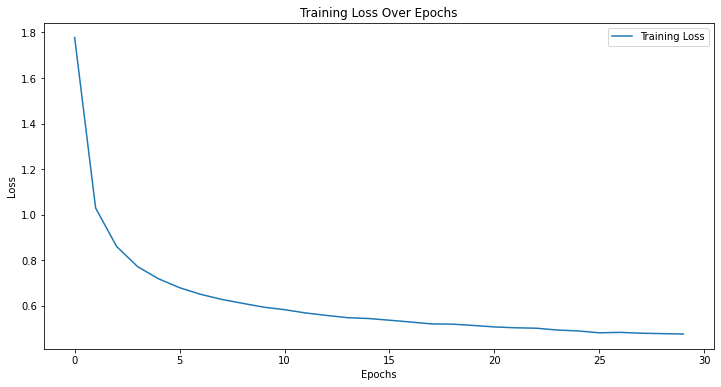

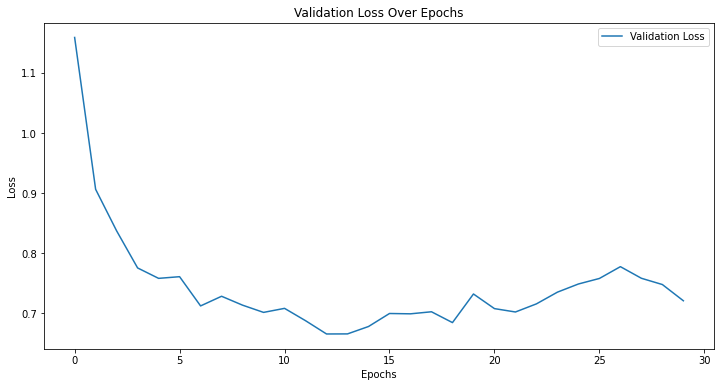

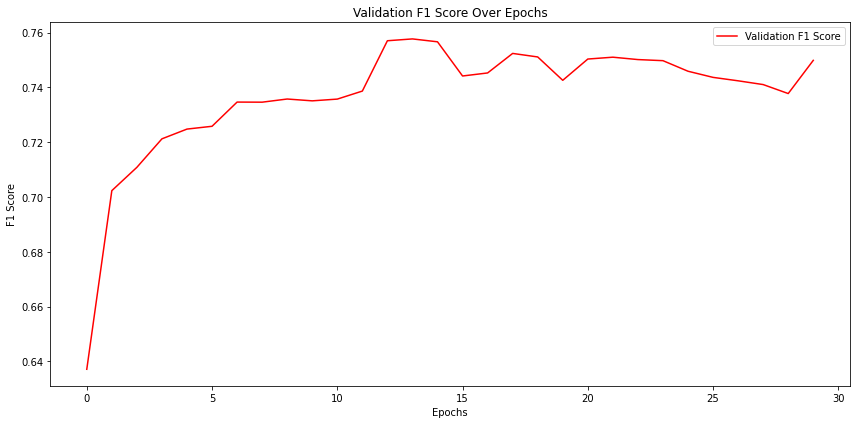

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(loss_values_train, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))

plt.plot(loss_values_val, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(f1_values, label='Validation F1 Score', color='red')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

mlp_model.load_state_dict(best_model_state)
mlp_model.to(device)
mlp_model.eval()

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=8)

test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = mlp_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_pred_labels = encoder.inverse_transform(test_preds)
test_true_labels = encoder.inverse_transform(test_labels)

print("Classification Report on Test Set (Using Loaded Model):")
print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set (Using Loaded Model):
                                precision    recall  f1-score   support

          Allergy / Immunology       0.92      1.00      0.96       227
                       Autopsy       1.00      1.00      1.00       221
                    Bariatrics       0.89      0.93      0.91       230
    Cardiovascular / Pulmonary       0.47      0.62      0.54       204
                  Chiropractic       0.77      0.80      0.79       210
    Consult - History and Phy.       0.18      0.07      0.10       229
    Cosmetic / Plastic Surgery       0.84      0.84      0.84       208
                     Dentistry       0.91      0.93      0.92       229
                   Dermatology       0.81      0.93      0.87       213
          Diets and Nutritions       0.91      1.00      0.95       209
             Discharge Summary       0.64      0.45      0.53       214
          ENT - Otolaryngology       0.85      0.76      0.80       204
       

# Test

In [31]:
import torch
from transformers import BertTokenizerFast, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

text = "my mom was diagnosed with bacterial pneumonia back in late december. after a round of antibiotics, she felt much better but the xray still showed pneumonia. a round of stronger antibiotics were then given to her. she went back for a follow up xray last week and the xray now shows the pneumonia is in both lungs. the strange thing is...she has no symptoms. no coughing, no fever, nothing. could it possibly be viral? or fluid? or cancer???? btw she has never smoked in her life."

inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    model_output = bert_model(**inputs)
    embedding = model_output.last_hidden_state.mean(dim=1)

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(embedding)
    probabilities = F.softmax(logits, dim=1)
    top_prob, top_lbls = torch.topk(probabilities, 5)

predicted_classes = encoder.inverse_transform(top_lbls.cpu().numpy()[0])

print("Top 5 Predicted Medical Specialties with Confidence:")
for probability, label in zip(top_prob.cpu().numpy()[0], predicted_classes):
    print(f"{label}: {probability:.4f}")

Top 5 Predicted Medical Specialties with Confidence:
 Hematology - Oncology: 0.6930
 Neurology: 0.0968
 Ophthalmology: 0.0560
 General Medicine: 0.0462
 SOAP / Chart / Progress Notes: 0.0455


In [32]:
import torch
from transformers import BertTokenizerFast, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

text = "patient: hi, may i answer your health queries right now ? please type your query here...i am 42 year old female with known case of pneumonia and constant coughing and low body temp of 35.3c feeling anemic advise please ? currently using bioxin and guafinicine/codein"
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    model_output = bert_model(**inputs)
    embedding = model_output.last_hidden_state.mean(dim=1)

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(embedding)
    probabilities = F.softmax(logits, dim=1)
    top_prob, top_lbls = torch.topk(probabilities, 5)

predicted_classes = encoder.inverse_transform(top_lbls.cpu().numpy()[0])

print("Top 5 Predicted Medical Specialties with Confidence:")
for probability, label in zip(top_prob.cpu().numpy()[0], predicted_classes):
    print(f"{label}: {probability:.4f}")

Top 5 Predicted Medical Specialties with Confidence:
 Neurology: 0.3560
 Emergency Room Reports: 0.3071
 Letters: 0.2149
 Nephrology: 0.0696
 General Medicine: 0.0372


In [35]:
import torch
from transformers import BertTokenizerFast, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

text = "dear doctor my littel son 11 months when he was 2 months and 15 days he got chest infection pneumonia in the right lung and after 2 weeks of treatment in the hospital with antibiotic he discharged next day he was admitted again with new infected by pneumonia in the right lung and then doctor did some test a barium swallow and ph. the resulte ge reflux grade 4. he was with ngt and ar formula by ngt for 3 moths with zantac and motinorm also with sitting position ,but all of those dosn t change any thing.after that when he was 5 months and 15 days he had an a laparoscopic fundoplication 5 ports, 360m degree wrap over 10fr ryles tube. he trying to vomit but he can t.i observed every time when he trying to vomit like for 5 to 7 minutes and when he sneeze every time after trying vomit then he got back to normal after sneezing.. and he drinking now neocate formula based on free amino acid. also he is allergy with lots of food ,."
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    model_output = bert_model(**inputs)
    embedding = model_output.last_hidden_state.mean(dim=1)

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(embedding)
    probabilities = F.softmax(logits, dim=1)
    top_prob, top_lbls = torch.topk(probabilities, 5)

predicted_classes = encoder.inverse_transform(top_lbls.cpu().numpy()[0])

print("Top 5 Predicted Medical Specialties with Confidence:")
for probability, label in zip(top_prob.cpu().numpy()[0], predicted_classes):
    print(f"{label}: {probability:.4f}")

Top 5 Predicted Medical Specialties with Confidence:
 Neurosurgery: 0.8268
 Neurology: 0.0880
 Chiropractic: 0.0503
 SOAP / Chart / Progress Notes: 0.0263
 Cosmetic / Plastic Surgery: 0.0031


In [36]:
import torch
from transformers import BertTokenizerFast, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

text = "patient: i have tonsillitis long time ago and every year i feel allergic problem in my thort. about 7 days i feel same allergic problem in my thort and tongue i have 1 canker sore. i take just anti histamine. but ago i treat this with prednisone. does it covid 19?"
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    model_output = bert_model(**inputs)
    embedding = model_output.last_hidden_state.mean(dim=1)

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(embedding)
    probabilities = F.softmax(logits, dim=1)
    top_prob, top_lbls = torch.topk(probabilities, 5)

predicted_classes = encoder.inverse_transform(top_lbls.cpu().numpy()[0])

print("Top 5 Predicted Medical Specialties with Confidence:")
for probability, label in zip(top_prob.cpu().numpy()[0], predicted_classes):
    print(f"{label}: {probability:.4f}")

Top 5 Predicted Medical Specialties with Confidence:
 SOAP / Chart / Progress Notes: 0.7455
 Podiatry: 0.2489
 Chiropractic: 0.0030
 Ophthalmology: 0.0017
 Consult - History and Phy.: 0.0009
